## Anomaly detection in time series

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
plt.rcParams["figure.figsize"] = (9,6)

## Read the data
This is real-life data on CPU utilization of an EC2 instance in the AWS cloud. Data was recorded every 5 minutes, starting on February 14th at 14:30. The dataset contains 4032 data points. It is available through the Numenta Anomaly Benchmark (NAB) repository under the AGPL-3.0 license.

In [6]:
df = pd.read_csv('ec2_cpu_utilization.csv')
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [7]:
 anomalies_timestamp = [
    "2014-02-26 22:05:00",
    "2014-02-27 17:15:00"
]

In [8]:
# convert to timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [9]:
# add an anomaly label
df['is_anomaly'] = 1 # not an anomaly

for each in anomalies_timestamp:
    df.loc[df['timestamp'] == each, 'is_anomaly'] = -1 

df.head()

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


In [10]:
anomaly_df = df.loc[df['is_anomaly'] == -1]
inlier_df = df.loc[df['is_anomaly'] == 1]

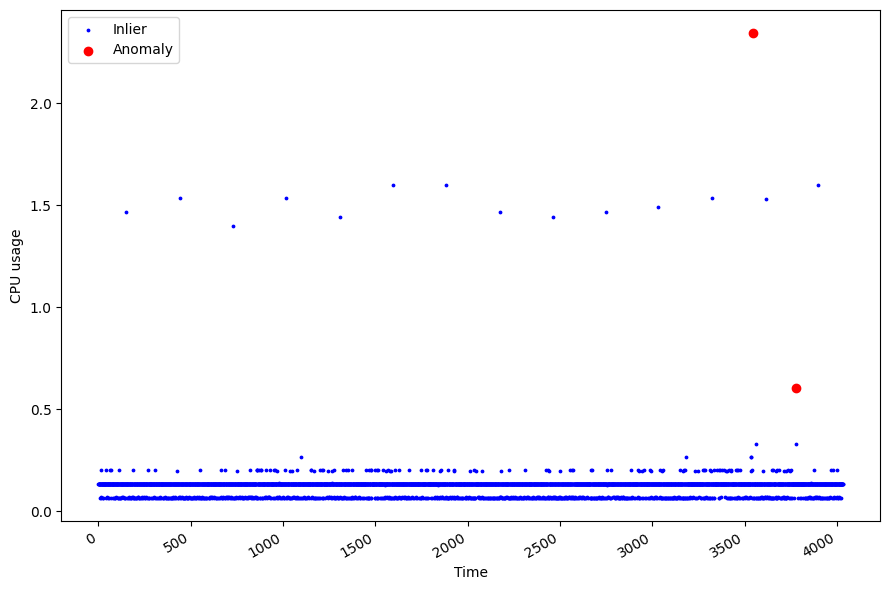

In [11]:
fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df['value'], color='blue', s=3, label='Inlier')
ax.scatter(anomaly_df.index, anomaly_df['value'], color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('CPU usage')
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()

## Baseline: Median Absolute Deviation (MAD)

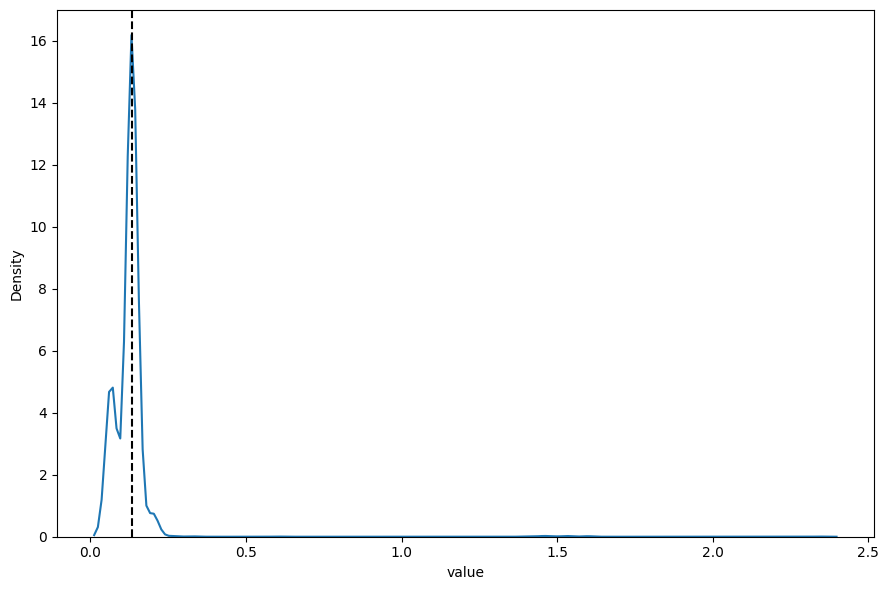

In [12]:
import seaborn as sns

sns.kdeplot(df['value']);
plt.grid(False)
plt.axvline(0.134, 0, 1, c='black', ls='--')
plt.tight_layout()

In [13]:
from scipy.stats import median_abs_deviation

mad = median_abs_deviation(df['value'])
median = np.median(df['value'])

print(median)
print(mad)

def compute_robust_z_score(x):
    return .6745*(x-median)/mad

0.134
0.0020000000000000018


In [14]:
df['z-score'] = df['value'].apply(compute_robust_z_score) # for each sample
df.head()

,timestamp,value,is_anomaly,z-score
0,2014-02-14 14:30:00,0.132,1,-0.6745
1,2014-02-14 14:35:00,0.134,1,0.0000
2,2014-02-14 14:40:00,0.134,1,0.0000
3,2014-02-14 14:45:00,0.134,1,0.0000
4,2014-02-14 14:50:00,0.134,1,0.0000


In [15]:
df['baseline'] = 1

df.loc[df['z-score'] >= 3.5, 'baseline'] = -1
df.loc[df['z-score'] <=-3.5, 'baseline'] = -1

## Evaluation

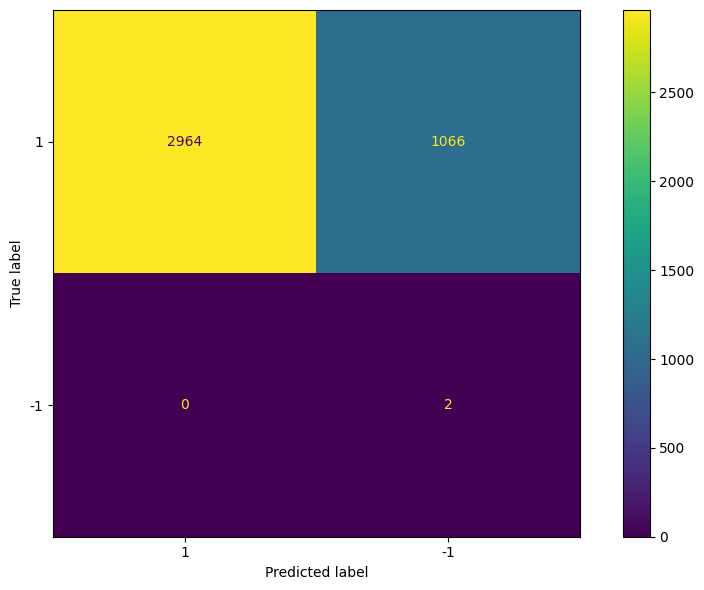

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df['is_anomaly'], df['baseline'], labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

## Isolation forest

In [17]:
from sklearn.ensemble import IsolationForest

In [18]:
# split the data (keep anomaly in the test set)
train = df[:3550]
test = df[3550:]

In [19]:
contamination = 1/len(train) # as we got 1 anomaly in the train set and one in the test set
iso_forest = IsolationForest(contamination=contamination, random_state=42)

X_train  =train['value'].values.reshape(-1,1)

iso_forest.fit(X_train)

IsolationForest(contamination=0.00028169014084507044, random_state=42)

In [20]:
preds_iso_forest = iso_forest.predict(test['value'].values.reshape(-1,1))

## Evaluation

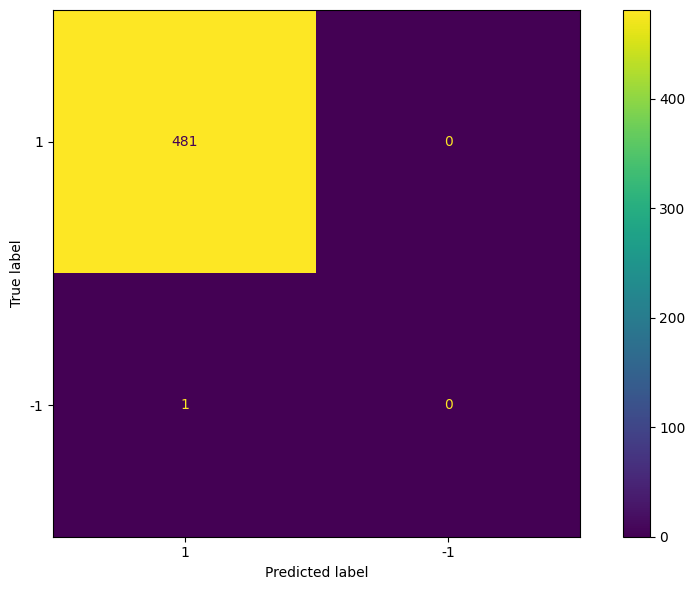

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test['is_anomaly'], preds_iso_forest, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

## Local Outlier Factor (LOF)

In [22]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(contamination=contamination, novelty=True)

lof.fit(X_train)

LocalOutlierFactor(contamination=0.00028169014084507044, novelty=True)

In [23]:
preds_lof = lof.predict(test['value'].values.reshape(-1,1))

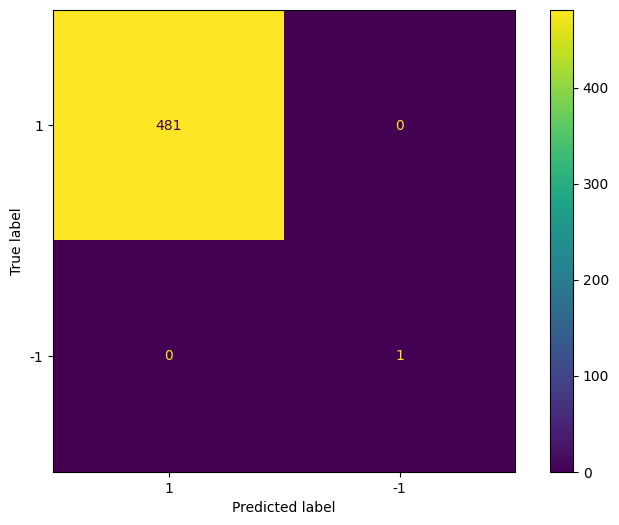

In [24]:
cm = confusion_matrix(test['is_anomaly'], preds_lof, labels=[1, -1])
disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])
disp_cm.plot();

**LOF was able to correctly identify the anomaly in the dataset, with no false positives or false negatives**